In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import scipy.stats as stats
import math
import seaborn as sns
import scipy.io
from scipy.stats.stats import pearsonr 
from runCPCA import runCPCA
from runCPCA import findLoadingsScores
from G_CPCA_Analysis import G_CPCA_Analysis
from getPcaPredCorr import getPcaPredCorr
from getPcaPredCorr import getPcaPredCorr2
from splitHalfCrossValidCpca import splitHalfCrossValidCpca
from splitHalfCrossValidCpca import runCpcaStep1
from SelectCompLoadingsBig import SelectCompLoadingsBig

In [2]:
dataZ = 'Z.mat'
dataG = 'G.mat'
#dataH = 'H.mat'
Z = scipy.io.loadmat(dataZ)
G = scipy.io.loadmat(dataG)
#H = scipy.io.loadmat(dataH)
Z = Z['Z']
G = G['G']
G=G.astype(np.int32) #very important!!
params={}
params['nIter']=100
params['varimaxFlag']=False
params['G_orig']=G
params['n_bootstrap']=100
params['p_val']=0.005 

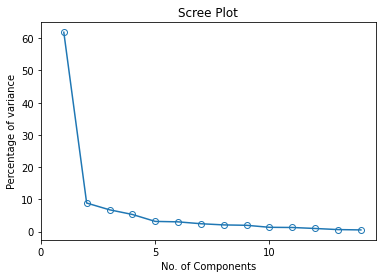

Enter the number of components: 3


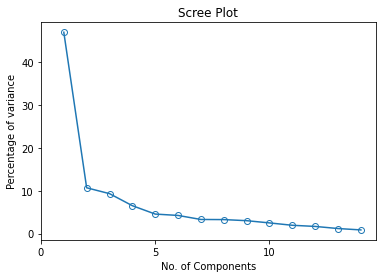

Enter the number of components: 3


Please wait…
10.0 % Completed!
20.0 % Completed!
30.0 % Completed!
40.0 % Completed!
50.0 % Completed!
60.0 % Completed!
70.0 % Completed!
80.0 % Completed!
90.0 % Completed!
100.0 % Completed!


In [3]:
G_CPCA_CV = splitHalfCrossValidCpca(Z, G, params)
BH_PCA_train = getPcaPredCorr(G_CPCA_CV['G_CPCA_train'], params)
BH_PCA_train['G_CPCA_CV'] = G_CPCA_CV
BH_PCA_test = getPcaPredCorr(G_CPCA_CV['G_CPCA_test'], params)
BH_PCA_test['G_CPCA_CV'] = G_CPCA_CV
## perform permutation tests
train_PCorr_shape=np.shape(BH_PCA_train['PCorr'])
permutePCorrTrain = np.zeros((train_PCorr_shape[0],train_PCorr_shape[1],train_PCorr_shape[2],params['n_bootstrap']))
permutePCorrTrain[:,:,:,:]=np.nan
test_PCorr_shape=np.shape(BH_PCA_test['PCorr'])
permutePCorrTest = np.zeros((test_PCorr_shape[0],test_PCorr_shape[1],test_PCorr_shape[2],params['n_bootstrap']))
permutePCorrTest[:,:,:,:]=np.nan
print('Please wait…')                          
for ii in range(0,params['n_bootstrap']):
    G_temp = np.random.permutation(G) 
    Z_temp = Z
    G_CPCA_CV_temp = splitHalfCrossValidCpca(Z_temp, G_temp, params)
    BH_PCA_temp = getPcaPredCorr2(G_CPCA_CV_temp['G_CPCA_train'], params, BH_PCA_train['nComp'])
    permutePCorrTrain[:,:,:,ii] = BH_PCA_temp['PCorr']
    BH_PCA_temp = getPcaPredCorr2(G_CPCA_CV_temp['G_CPCA_test'], params, BH_PCA_test['nComp'])
    permutePCorrTest[:,:,:,ii] = BH_PCA_temp['PCorr']
    if (ii+1)%10==0:
        print((1+ii)/params['n_bootstrap']*100,'% Completed!')
                            
#save('permutePCorr.mat','permutePCorrTest','permutePCorrTrain')
Test_s=np.shape(permutePCorrTest)
Train_s=np.shape(permutePCorrTrain)
permutePCorr_mat=np.zeros((Train_s[0],Train_s[1],Train_s[2],Test_s[3]+Train_s[3]))
for i in range(Test_s[3]+Train_s[3]):
    for j in range(Train_s[2]):
        for m in range(Train_s[1]):
            for n in range(Train_s[0]):
                if i<Test_s[3]:
                    permutePCorr_mat[n,m,j,i]=permutePCorrTrain[n,m,j,i]
                else:
                    permutePCorr_mat[n,m,j,i]=permutePCorrTest[n,m,j,i-Test_s[3]]
np.save('permutePCorr',permutePCorr_mat)

BH_PCA_train['permutePCorrMean'] = np.nanmean(permutePCorrTrain,axis=2)
BH_PCA_test['permutePCorrMean'] = np.nanmean(permutePCorrTest,axis=2)

absPermutePCorrMean_list=list()
for i in range(0,np.shape(BH_PCA_train['permutePCorrMean'])[2]):
    for j in range(0,np.shape(BH_PCA_train['permutePCorrMean'])[1]):
        for k in range(0,np.shape(BH_PCA_train['permutePCorrMean'])[0]):
            list.append(absPermutePCorrMean_list,abs(BH_PCA_train['permutePCorrMean'][k,j,i]))
BH_PCA_train['predrel_cutoff'] = np.quantile(absPermutePCorrMean_list, 1-params['p_val'],interpolation='nearest')
absPermutePCorrMean_list=list()
for i in range(0,np.shape(BH_PCA_test['permutePCorrMean'])[2]):
    for j in range(0,np.shape(BH_PCA_test['permutePCorrMean'])[1]):
        for k in range(0,np.shape(BH_PCA_test['permutePCorrMean'])[0]):
            list.append(absPermutePCorrMean_list,abs(BH_PCA_test['permutePCorrMean'][k,j,i]))
BH_PCA_test['predrel_cutoff'] = np.quantile(absPermutePCorrMean_list, 1-params['p_val'],interpolation='nearest')

BH_PCA_train['meanPCorr'] = np.nanmean(BH_PCA_train['PCorr'],axis=2)
BH_PCA_test['meanPCorr'] = np.nanmean(BH_PCA_test['PCorr'],axis=2)

BH_PCA_train['RelPredLoadMask'] = abs(BH_PCA_train['meanPCorr']) >= BH_PCA_train['predrel_cutoff']
BH_PCA_test['RelPredLoadMask'] = abs(BH_PCA_test['meanPCorr']) >= BH_PCA_test['predrel_cutoff']

------------------------------------------------------------
Train data - Component Loadings
Chapter:……


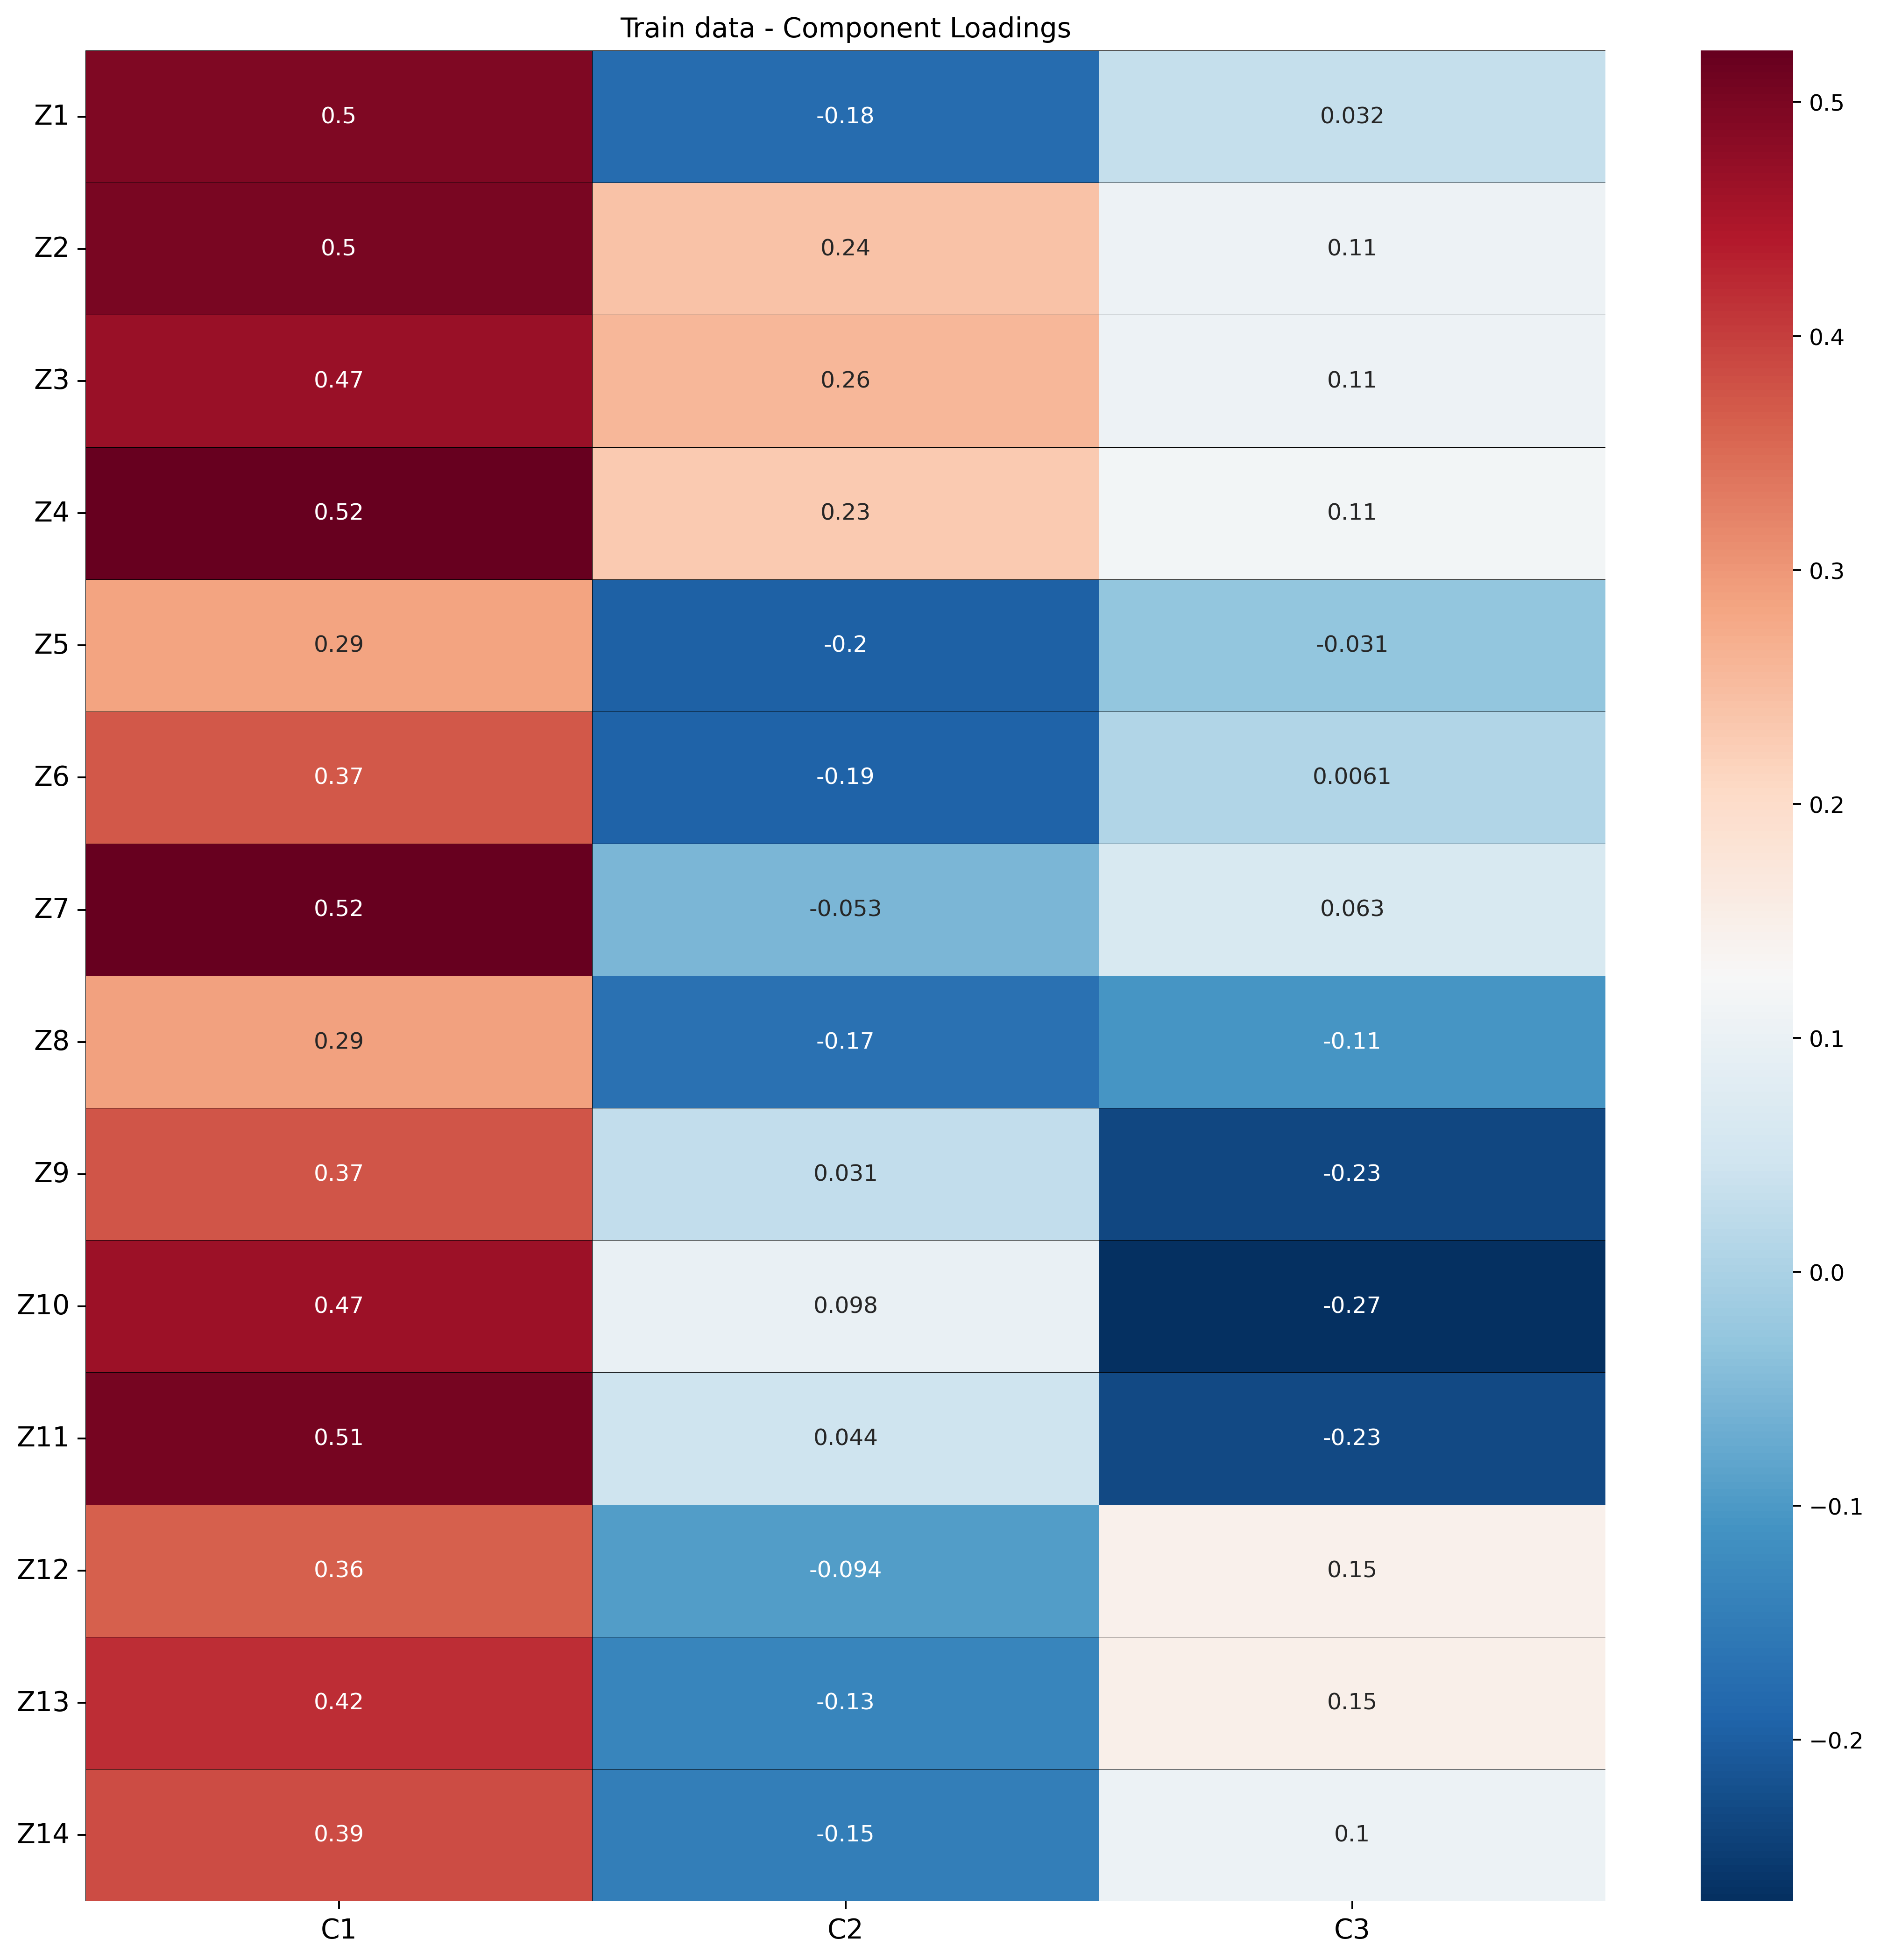

------------------------------------------------------------
------------------------------------------------------------
Train data - Predictor loading threshold - p <= 0.005
Estimated Predictor loading threshold = 0.33792471868661683 (at p<= 0.005 )


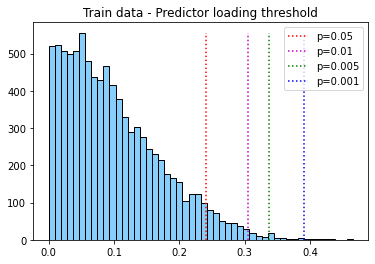

------------------------------------------------------------
------------------------------------------------------------
Train data - Predictor Loadings
Chapter:……


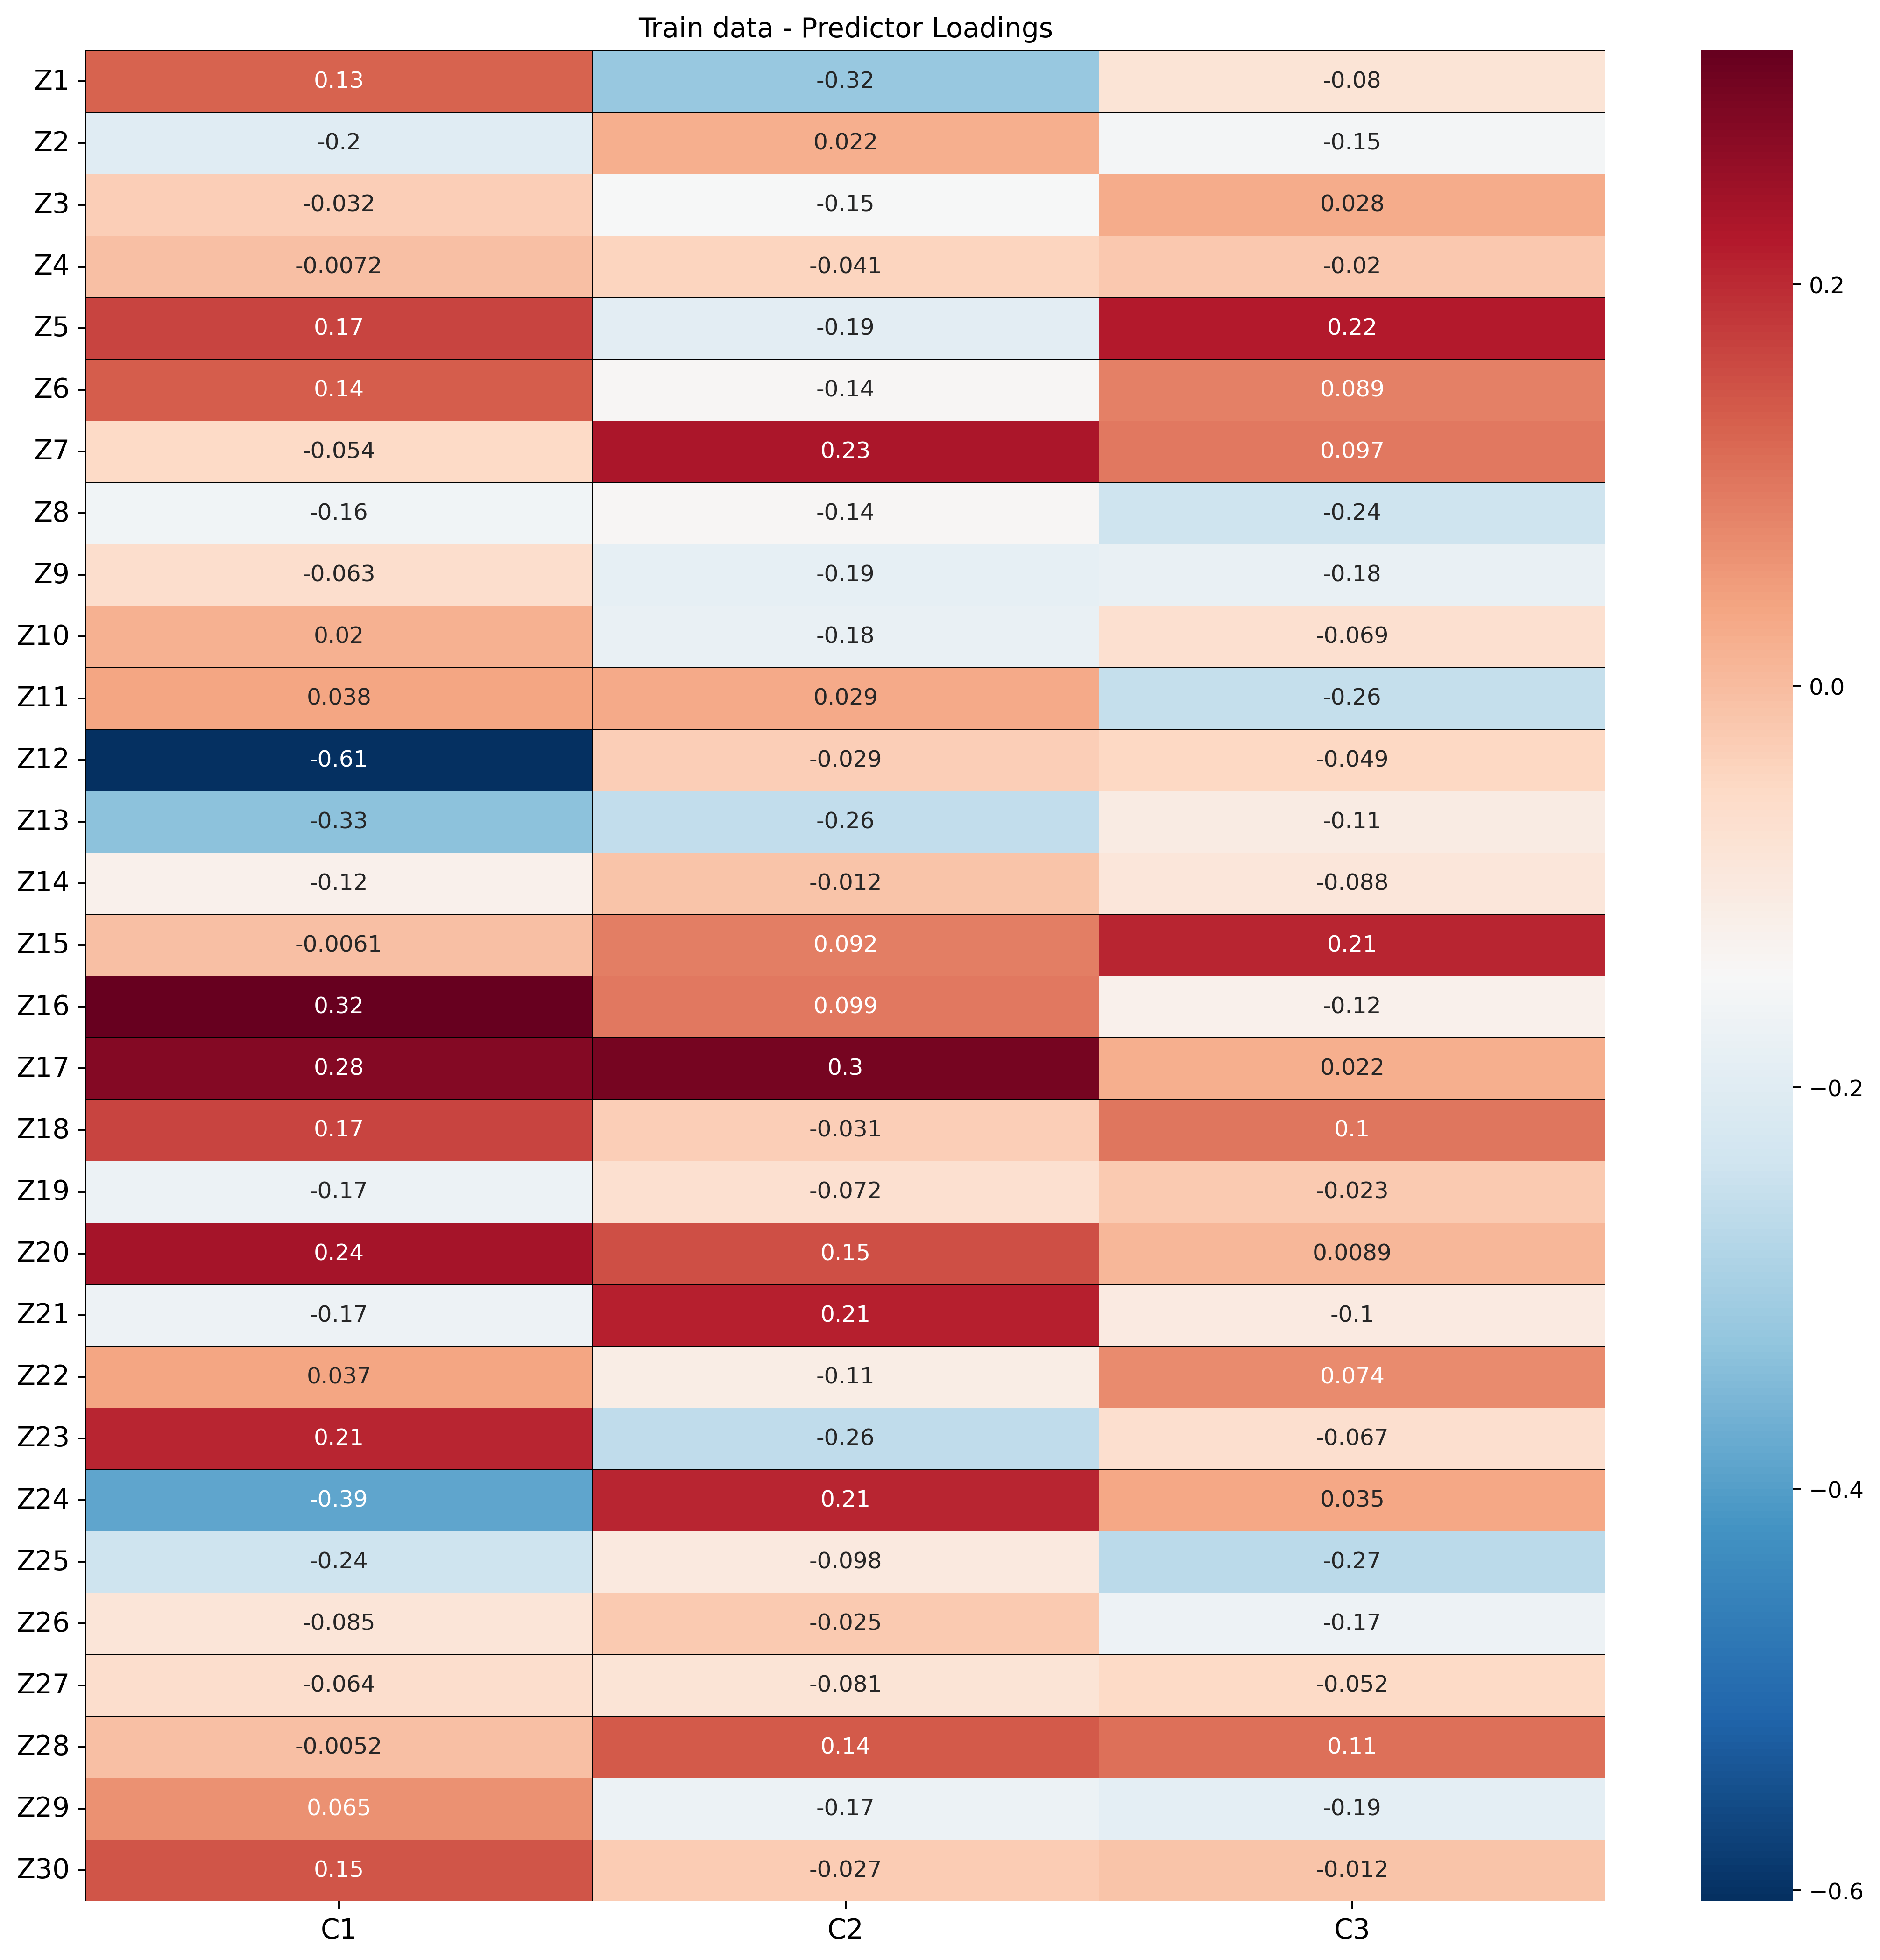

------------------------------------------------------------
------------------------------------------------------------
Train data - Dominant Component Loadings
Chapter:……


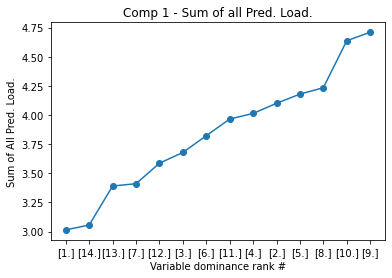

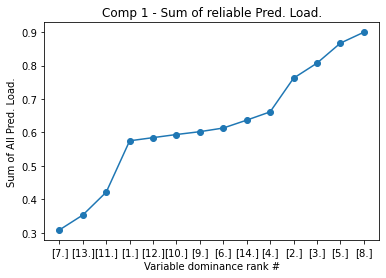

------------------------------------------------------------
------------------------------------------------------------
Test data - Component Loadings
Chapter:……


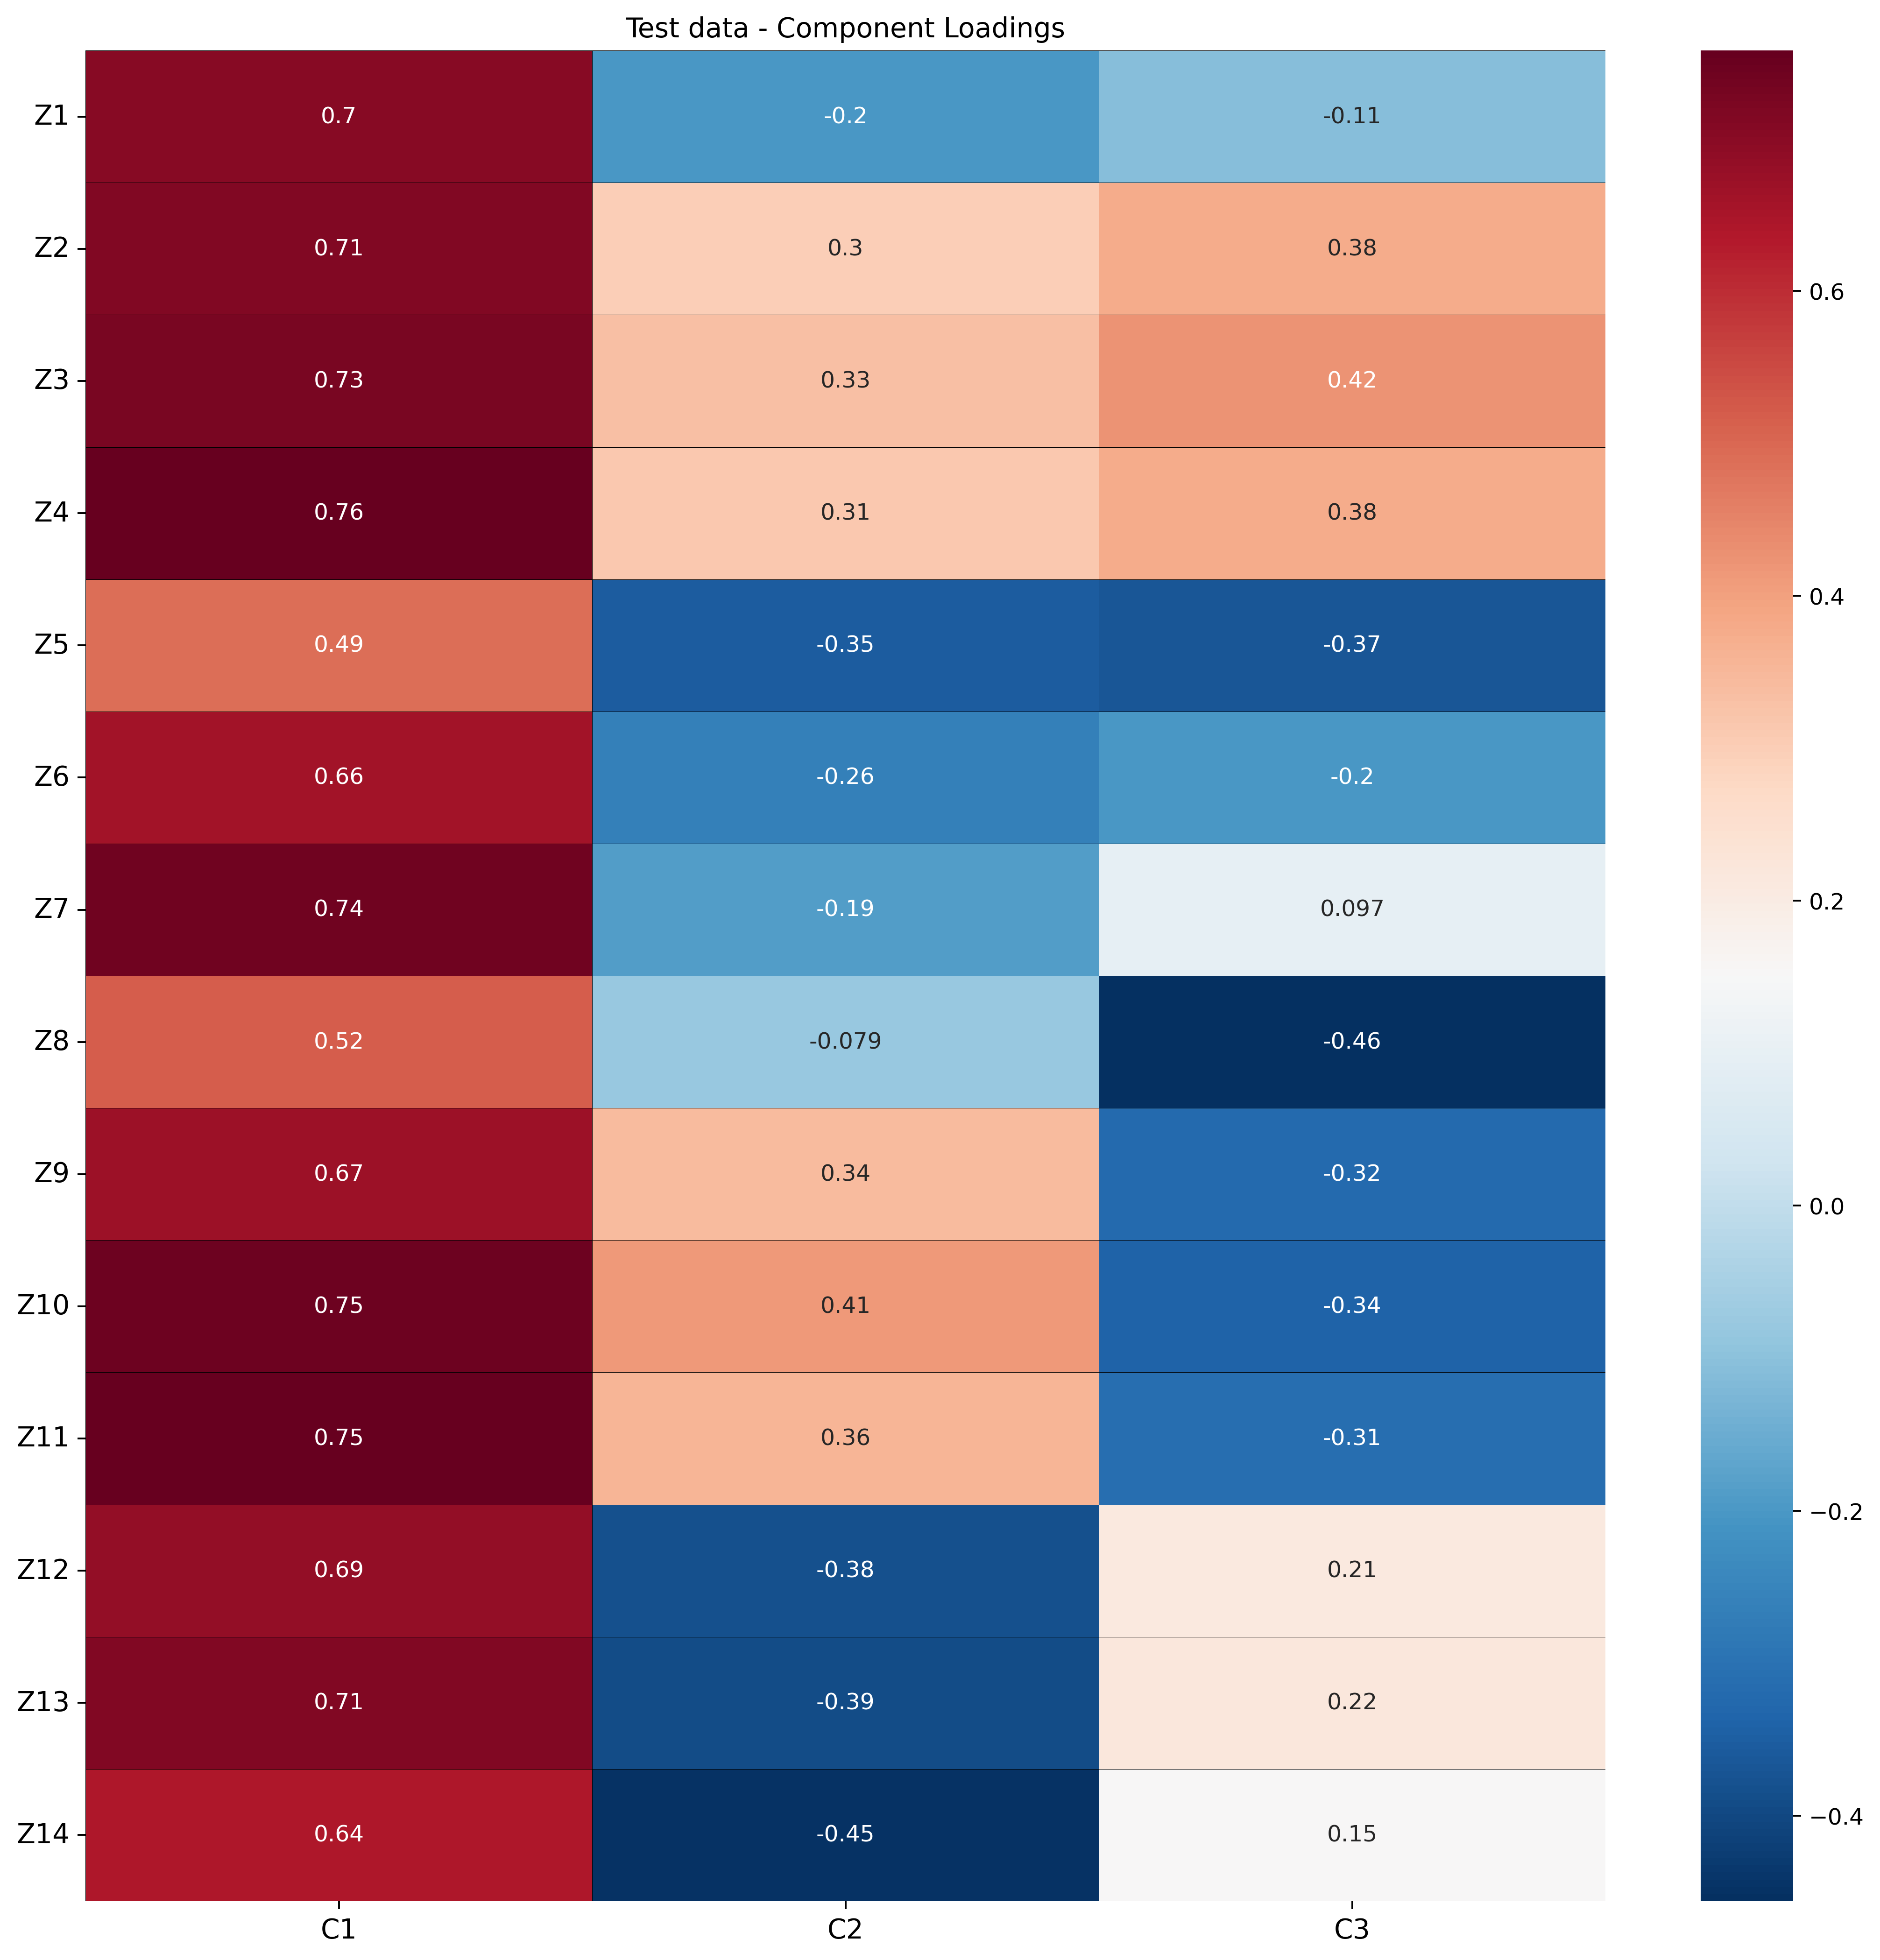

------------------------------------------------------------
------------------------------------------------------------
Test data - Predictor loading threshold - p <= 0.005
Estimated Predictor loading threshold = 0.16118235547961074 (at p<= 0.005 )


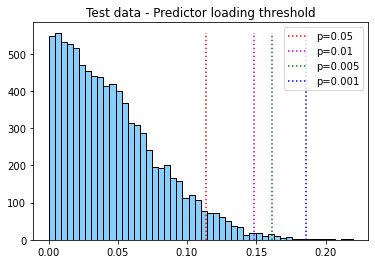

------------------------------------------------------------
------------------------------------------------------------
Test data - Predictor Loadings
Chapter:……


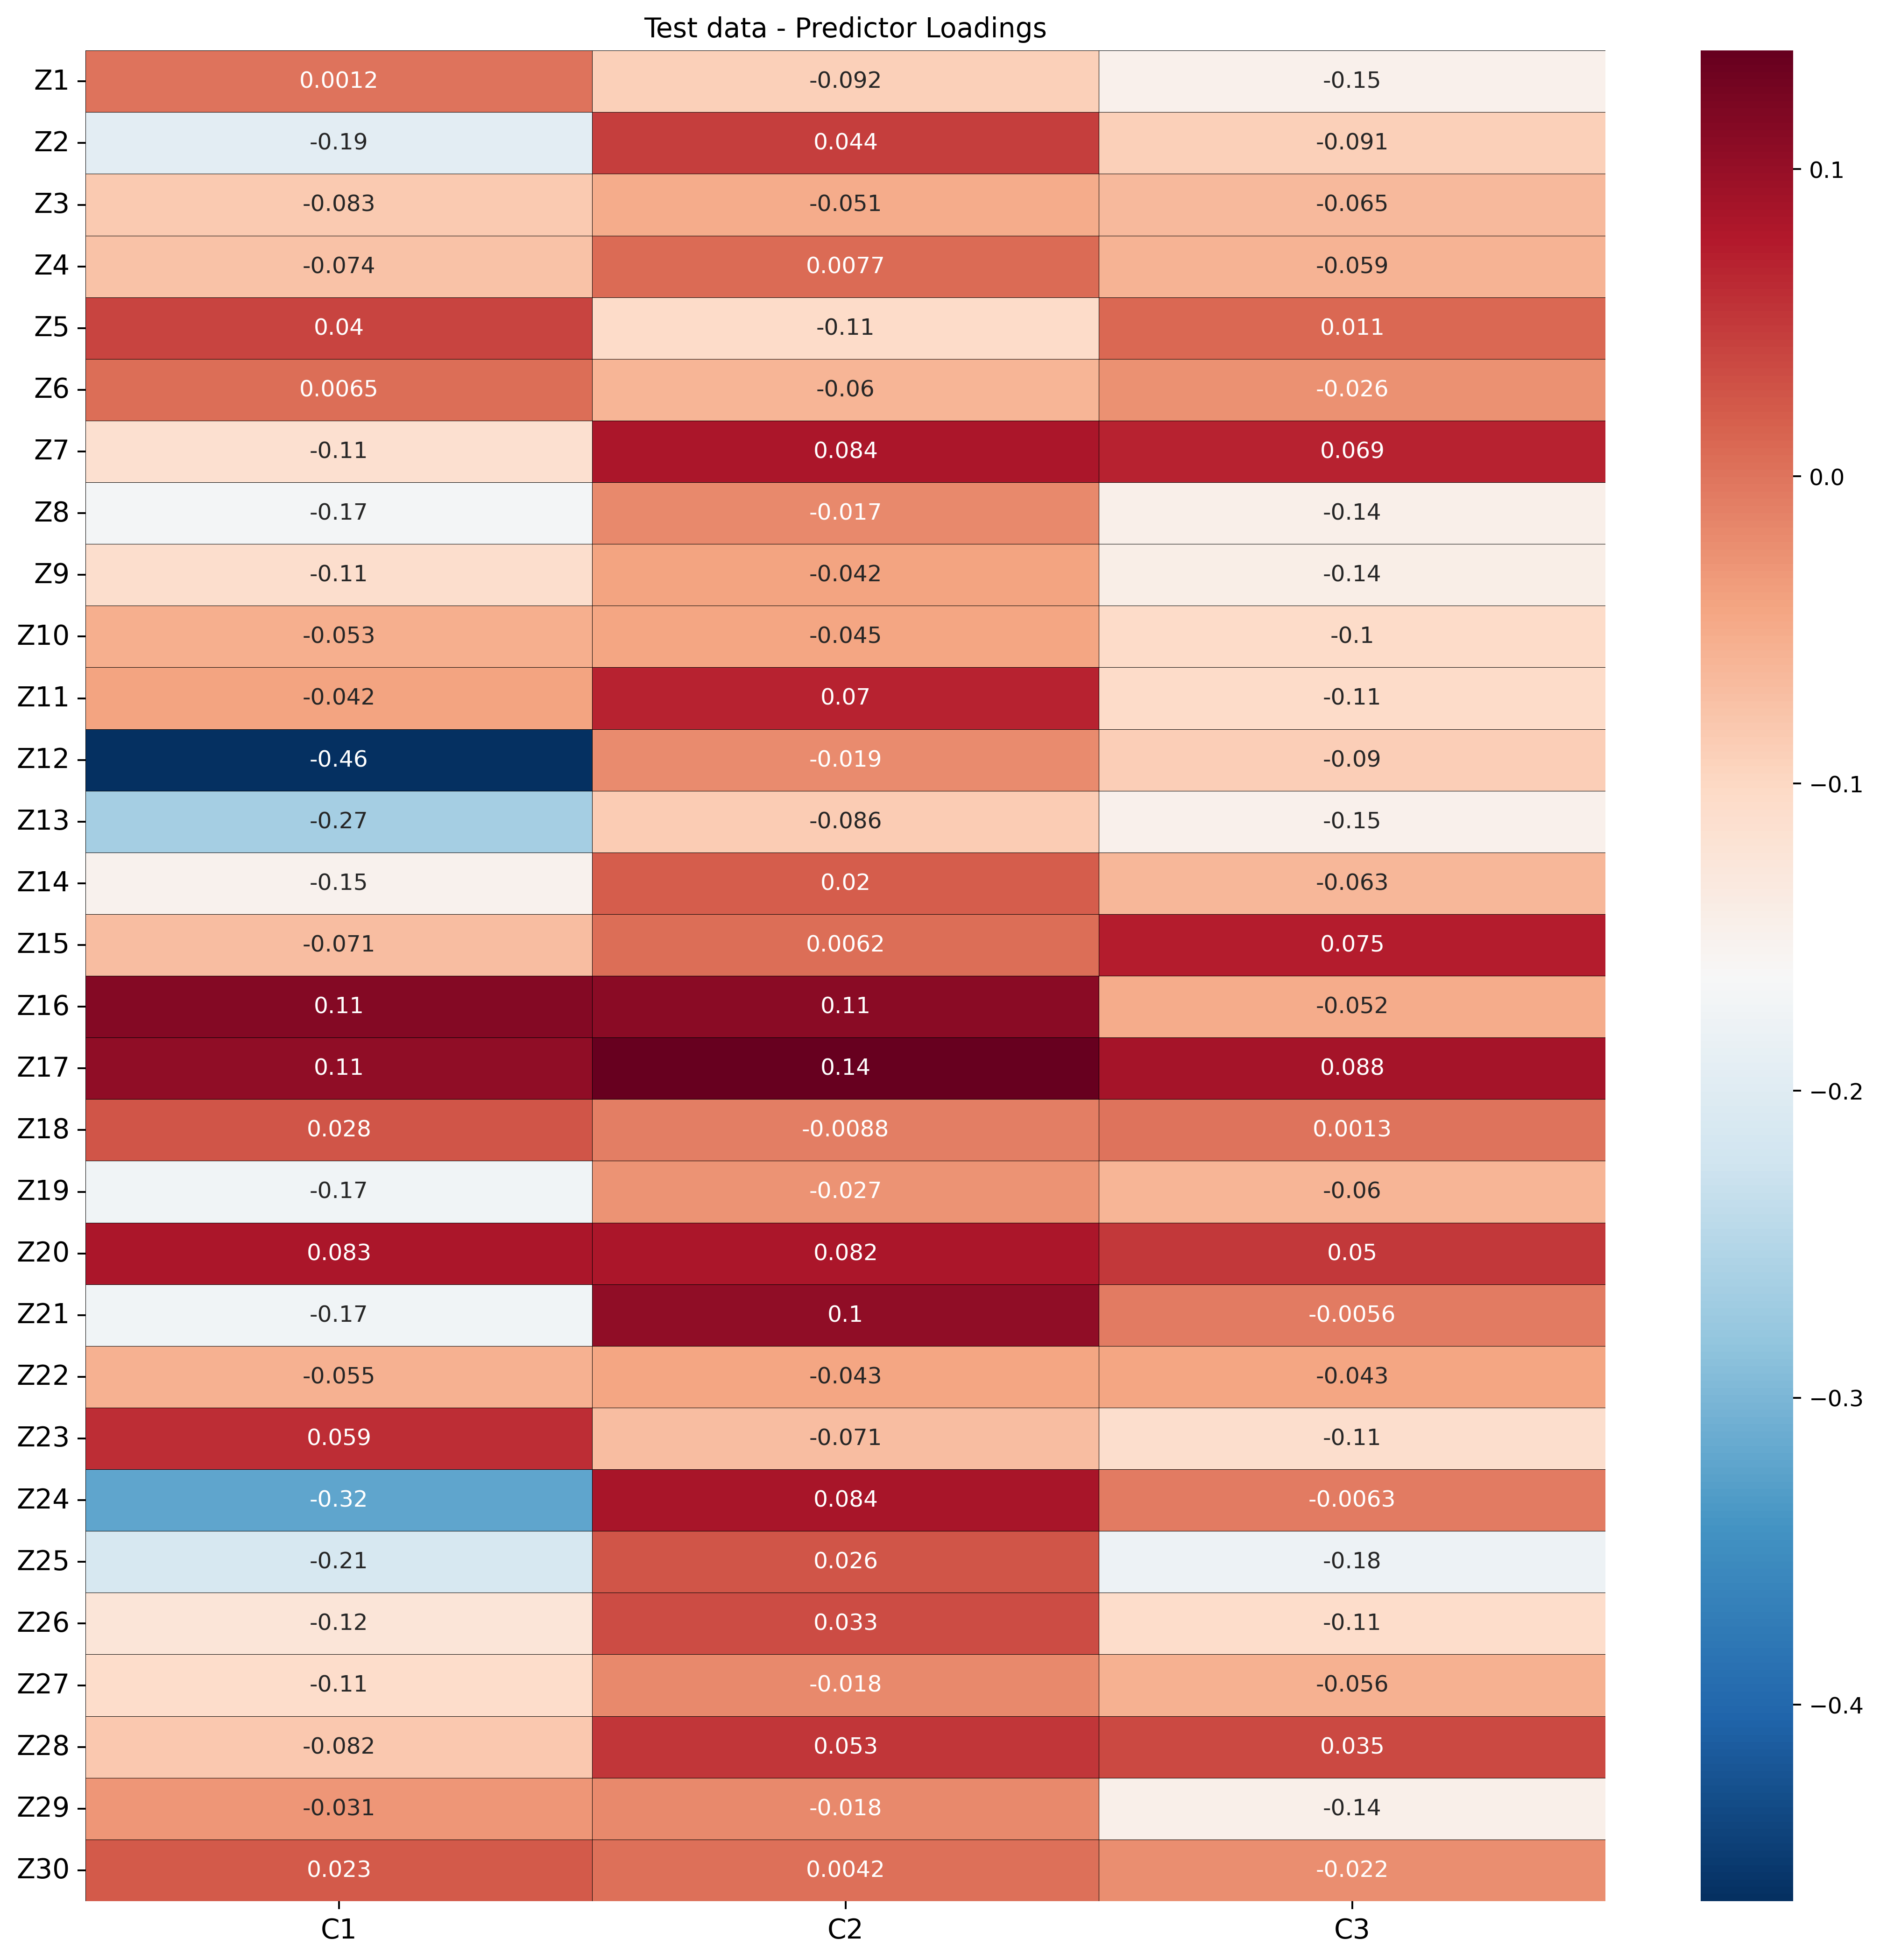

------------------------------------------------------------
------------------------------------------------------------
Test data - Predictor
Test data - Dominant Component Loadings
Chapter:……


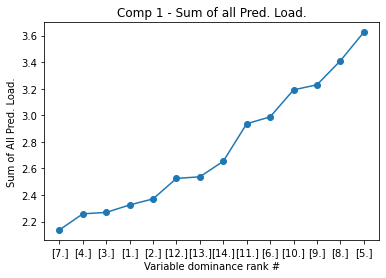

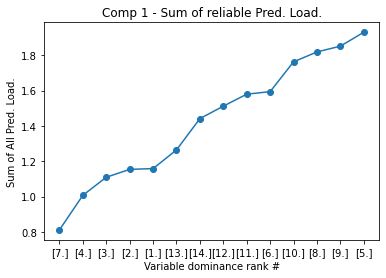

------------------------------------------------------------


In [13]:
##generate the report!
#Train:
print('------------------------------------------------------------')
print('Train data - Component Loadings')
print('Chapter:……')
temp = BH_PCA_train['loadings_VD_sqrtN_GH']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=list()
for i in range(0,n_Z):
    list.append(y_ticks,"Z%d"%(i+1))
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(15,15))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Train data - Component Loadings')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Train data - Predictor loading threshold - p <=',params['p_val'])
print('Estimated Predictor loading threshold =',BH_PCA_train['predrel_cutoff'],'(at p<=',params['p_val'],')')
predRel=list()
ppm_shape=np.shape(BH_PCA_train['permutePCorrMean'])
for i in range(ppm_shape[2]):
    for j in range(ppm_shape[1]):
        for k in range(ppm_shape[0]):
            list.append(predRel,abs(BH_PCA_train['permutePCorrMean'][k,j,i]))
his=plt.hist(predRel,bins=50,color='lightskyblue',edgecolor='k')
plt.vlines(np.quantile(predRel, 1-0.05,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='r',linestyles='dotted',label='p=0.05')
plt.vlines(np.quantile(predRel, 1-0.01,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='m',linestyles='dotted',label='p=0.01')
plt.vlines(np.quantile(predRel, 1-0.005,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='g',linestyles='dotted',label='p=0.005')
plt.vlines(np.quantile(predRel, 1-0.001,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='b',linestyles='dotted',label='p=0.001')
plt.legend()
plt.title('Train data - Predictor loading threshold')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Train data - Predictor Loadings')
print('Chapter:……')
temp = BH_PCA_train['meanPCorr']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=list()
for i in range(0,n_Z):
    list.append(y_ticks,"Z%d"%(i+1))
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(15,15))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Train data - Predictor Loadings')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
BH_PCA_train['Res']=SelectCompLoadingsBig(BH_PCA_train, params)
print('Train data - Dominant Component Loadings')
print('Chapter:……')
comp_rel=np.where(any(sum(BH_PCA_train['RelPredLoadMask'])))
sumPredLoad=BH_PCA_train['Res']['0']['SumPredLoad']
for ii in range(1,len(BH_PCA_train['Res'])):
    sumPredLoad=np.row_stack((sumPredLoad,BH_PCA_train['Res'][str(ii)]['SumPredLoad']))
sumPredLoadRel=BH_PCA_train['Res']['0']['SumPredLoadRel']
for ii in range(1,len(BH_PCA_train['Res'])):
    sumPredLoadRel=np.row_stack((sumPredLoadRel,BH_PCA_train['Res'][str(ii)]['SumPredLoadRel']))
sumPredLoadSort=np.zeros(np.shape(sumPredLoad))
sumPredLoadSortIdx=np.zeros(np.shape(sumPredLoad))
for ii in range(np.shape(sumPredLoad)[1]):
    sumPredLoadSort[:,ii] = sorted(sumPredLoad[:,ii])
    sumPredLoadSortIdx[:,ii] = sorted(range(len(sumPredLoad[:,ii])), key = lambda x:sumPredLoad[x,ii])
sumPredLoadRelSort=np.zeros(np.shape(sumPredLoadRel))
sumPredLoadRelSortIdx=np.zeros(np.shape(sumPredLoadRel))
for ii in range(np.shape(sumPredLoadRel)[1]):
    sumPredLoadRelSort[:,ii] = sorted(sumPredLoadRel[:,ii])
    sumPredLoadRelSortIdx[:,ii] = sorted(range(len(sumPredLoadRel[:,ii])), key = lambda x:sumPredLoadRel[x,ii])
for ii in comp_rel:
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadSort)[0]),sumPredLoadSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadSortIdx)[0]):
        list.append(xticks,str(sumPredLoadSortIdx[i,ii]+1))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of all Pred. Load.'%(ii+1))
    plt.show()
for ii in comp_rel:
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadRelSort)[0]),sumPredLoadRelSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadRelSortIdx)[0]):
        list.append(xticks,str(sumPredLoadRelSortIdx[i,ii]+1))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadRelSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of reliable Pred. Load.'%(ii+1))
    plt.show()
print('------------------------------------------------------------')
#Test:
##generate the report!
print('------------------------------------------------------------')
print('Test data - Component Loadings')
print('Chapter:……')
temp = BH_PCA_test['loadings_VD_sqrtN_GH']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=list()
for i in range(0,n_Z):
    list.append(y_ticks,"Z%d"%(i+1))
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(15,15))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Test data - Component Loadings')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Test data - Predictor loading threshold - p <=',params['p_val'])
print('Estimated Predictor loading threshold =',BH_PCA_test['predrel_cutoff'],'(at p<=',params['p_val'],')')
predRel=list()
ppm_shape=np.shape(BH_PCA_test['permutePCorrMean'])
for i in range(ppm_shape[2]):
    for j in range(ppm_shape[1]):
        for k in range(ppm_shape[0]):
            list.append(predRel,abs(BH_PCA_test['permutePCorrMean'][k,j,i]))
his=plt.hist(predRel,bins=50,color='lightskyblue',edgecolor='k')
plt.vlines(np.quantile(predRel, 1-0.05,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='r',linestyles='dotted',label='p=0.05')
plt.vlines(np.quantile(predRel, 1-0.01,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='m',linestyles='dotted',label='p=0.01')
plt.vlines(np.quantile(predRel, 1-0.005,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='g',linestyles='dotted',label='p=0.005')
plt.vlines(np.quantile(predRel, 1-0.001,interpolation='nearest'),ymin=0,ymax=max(his[0]),colors='b',linestyles='dotted',label='p=0.001')
plt.legend()
plt.title('Test data - Predictor loading threshold')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Test data - Predictor Loadings')
print('Chapter:……')
temp = BH_PCA_test['meanPCorr']
n_Z,n_C = np.shape(temp)
x_ticks=list()
y_ticks=list()
for i in range(0,n_Z):
    list.append(y_ticks,"Z%d"%(i+1))
for i in range(0,n_C):
    list.append(x_ticks,"C%d"%(i+1))
plt.figure(dpi=350,figsize=(15,15))
h=sns.heatmap(temp,annot=True,cmap='RdBu_r',xticklabels=x_ticks,yticklabels=y_ticks,linewidths=0.2,linecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
#plt.annotate()#
h.set_title('Test data - Predictor Loadings')
plt.show()
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('Test data - Predictor') 

BH_PCA_test['Res']=SelectCompLoadingsBig(BH_PCA_test, params)

print('Test data - Dominant Component Loadings')
print('Chapter:……')
comp_rel=np.where(any(sum(BH_PCA_test['RelPredLoadMask'])))
sumPredLoad=BH_PCA_test['Res']['0']['SumPredLoad']
for ii in range(1,len(BH_PCA_test['Res'])):
    sumPredLoad=np.row_stack((sumPredLoad,BH_PCA_test['Res'][str(ii)]['SumPredLoad']))
sumPredLoadRel=BH_PCA_test['Res']['0']['SumPredLoadRel']
for ii in range(1,len(BH_PCA_test['Res'])):
    sumPredLoadRel=np.row_stack((sumPredLoadRel,BH_PCA_test['Res'][str(ii)]['SumPredLoadRel']))
sumPredLoadSort=np.zeros(np.shape(sumPredLoad))
sumPredLoadSortIdx=np.zeros(np.shape(sumPredLoad))
for ii in range(np.shape(sumPredLoad)[1]):
    sumPredLoadSort[:,ii] = sorted(sumPredLoad[:,ii])
    sumPredLoadSortIdx[:,ii] = sorted(range(len(sumPredLoad[:,ii])), key = lambda x:sumPredLoad[x,ii])
sumPredLoadRelSort=np.zeros(np.shape(sumPredLoadRel))
sumPredLoadRelSortIdx=np.zeros(np.shape(sumPredLoadRel))
for ii in range(np.shape(sumPredLoadRel)[1]):
    sumPredLoadRelSort[:,ii] = sorted(sumPredLoadRel[:,ii])
    sumPredLoadRelSortIdx[:,ii] = sorted(range(len(sumPredLoadRel[:,ii])), key = lambda x:sumPredLoadRel[x,ii])
for ii in comp_rel:
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadSort)[0]),sumPredLoadSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadSortIdx)[0]):
        list.append(xticks,str(sumPredLoadSortIdx[i,ii]+1))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of all Pred. Load.'%(ii+1))
    plt.show()
for ii in comp_rel:
    plt.figure()
    s = plt.plot(np.arange(np.shape(sumPredLoadRelSort)[0]),sumPredLoadRelSort[:,ii],'o-')
    xticks=list()
    for i in range(np.shape(sumPredLoadRelSortIdx)[0]):
        list.append(xticks,str(sumPredLoadRelSortIdx[i,ii]+1))
    plt.xlabel('Variable dominance rank #')
    plt.xticks(np.arange(np.shape(sumPredLoadRelSort)[0]),xticks)
    plt.ylabel('Sum of All Pred. Load.')
    plt.title('Comp %d - Sum of reliable Pred. Load.'%(ii+1))
    plt.show()
print('------------------------------------------------------------')